Assignment 5

## GitHub User Name: aton-physics

## Email: andrew_ton@brown.edu


## Problem 1
Simulate a random walk in three dimensions allowing the walker to make steps of unit
length in random directions; don’t restrict the walker to sites on a discrete lattice i.e let
the angle defining the step direction vary continuously between [−π/2, π/2]. Show that
the motion is diffusive, i.e. $\langle r^2\rangle$ ∝ t. Find the value of the proportionality constant.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# we will use numba again
from numba import jit
import matplotlib.cm as cm

In [69]:
from random import gauss

def make_rand_vector(dims=3):
    vec = [gauss(0, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return [x/mag for x in vec]

def make_rand_array(length): #unit vector of a certain length
    dirx = np.zeros(length)
    diry = dirx
    dirz = dirx
    for i in range(length):
        vec = make_rand_vector(3)
        dirx[i] = vec[0]
        diry[i] = vec[1]
        dirz[i] = vec[2]
    return dirx, diry, dirz

def randwalk(nsteps = 100, nsamples = 1000):
    nsteps = int(nsteps)
    nsamples = int(nsamples)
    rms = np.zeros(nsteps)
    trajectories = np.zeros([nsamples, nsteps])
    #for ii in range nsamples:
        
    #to do the task, the hint is that the rng can return arrays too
    x0 = 2*np.random.randint(0,1+1,(nsamples,nsteps-1)) - 1
    y0 = 2*np.random.randint(0,1+1,(nsamples,nsteps-1)) - 1
    z0 = 2*np.random.randint(0,1+1,(nsamples,nsteps-1)) - 1
    x0 = np.insert(x0,0,0,axis=1)
    y0 = np.insert(y0,0,0,axis=1)
    z0 = np.insert(z0,0,0,axis=1)
    dirx = np.zeros(len(x0)*len(x0[0]))
    diry = dirx
    dirz = dirx
    dirx, diry, dirz = make_rand_array(len(x0)*len(x0[0]))
    dirx = np.reshape(dirx, [nsamples,nsteps])
    diry = np.reshape(diry, [nsamples,nsteps])
    dirz = np.reshape(dirz, [nsamples,nsteps])
    np.multiply(x0, dirx)
    np.multiply(y0, diry)
    np.multiply(z0, dirz)

    traj = np.cumsum(x0,axis=1) + np.cumsum(y0,axis=1) + np.cumsum(z0,axis=1)
    rms = np.sum(traj**2,axis=0)
    return rms/nsamples, traj



In [70]:
#%%timeit   # run some timing routines on the current cell, only uncomment for testing purposes, se
#871 +- 5 ms for python for-loop
#331 +- 3 ms for np loops
nsteps = 500
nsamples = 2e3
rms, trajectories = randwalk(nsteps, nsamples)

In [ ]:
# function to make a straight line
# lambda is a special constructor to create functions on the fly
linear = lambda D, x : 2*D*x

# the above could also be written as 
# def linear(D,x):
#    return 2*D*x

steps = np.arange(len(rms))
nsteps = 500
nsamples = 2e4
rms, trajectories = randwalk(nsteps, nsamples)


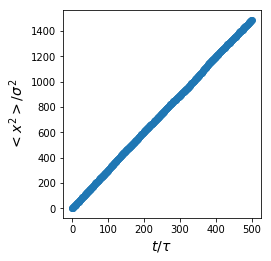

The value of the proportionality constant is:  0.335513343448 σ^2/τ


In [139]:
fig = plt.figure(figsize = (8,4))
ax2 = fig.add_subplot(122)
ax2.plot(rms, 'o')

ax2.set_xlabel(r'$t/\tau$', fontsize =14)
ax2.set_ylabel('$<x^2>/\sigma^2$', fontsize = 14)

fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.45, hspace = 0.35)
plt.show()

from scipy.optimize import curve_fit

def f(x, A, B): #  'straight line' y=f(x)
    return A*x + B

A,B = curve_fit(f, rms, np.arange(0,nsteps))[0] # your data x, y to fit
print("The value of the proportionality constant is: ", A, 'σ^2/τ')


Here the step number is taken to be $\tau$ with units of time, and the length of each step is taken to be $\sigma$.

It is clear that the graph is linear in $\frac{t}{\tau}$.

## Problem 2

Simulate an ensemble of random walkers in two dimensions, constrained to a 100 by
100 square lattice, and starting with an initial distribution in which all of the particles
are near the center. Let one of the walls of the container have a small hole of 10
units in length along the edge through which particles can leave the container. Once a
particle has left the container, it cannot reenter. Calculate the number of particles in
the container as a function of time and show that it varies as $\exp(−t/τ)$, where τ is
an effective time constant for the escape time.

In [118]:
@jit(nopython=True)
def step_2d():
    # step for random walk on 2D square lattice
    d = np.random.randint(1,5) #2d => need 4 numbers
    if d == 1:
        x_s, y_s = 1, 0
    if d == 2:
        x_s, y_s = 0, 1
    if d == 3:
        x_s, y_s = -1, 0
    if d == 4:
        x_s, y_s = 0, -1
    return [x_s, y_s]


@jit(nopython=True)
def randwalk_2d(nsteps, wall = 1e6):#set up x and y coordinates
   # trajectory for a single 2D random walk
    x = np.zeros(nsteps+1, np.double)
    y = np.zeros(nsteps+1, np.double)
    NumWalkers = np.zeros(nsteps+1)
    for i in range(nsteps):
        s = step_2d()
        x[i+1] = x[i] + s[0]
        if abs(x[i+1]) > wall:
            x[i+1] = x[i] #check if inside or outside of box
            if abs(y[i+1]) < 5: 
                #small hole that particles can escape through
                return 1, i+1
        y[i+1] = y[i] + s[1]
        if abs(y[i+1]) > wall: 
            y[i+1] = y[i]
        
    #return x, y 
    return 0, 0

@jit(nopython=True)
def ensemble_2d(N,t_max, wall = 1e6):#collect many together
    #generate an ensemble or random walkers
    xh = np.zeros(N, np.double)
    yh = np.zeros(N, np.double)
    
    NumWalkers = N
    
    exit_times = np.zeros(N)

    for i in range(N):
        x, y = randwalk_2d(t_max, wall)
        if x:
            exit_times[i] = y
        #xh[i] = x[-1]
        #yh[i] = y[-1]

    #return xh, yh
    return exit_times



In [131]:
t=10000
N=5000
exit_times = ensemble_2d(N, t_max = t,wall =50)
Counter = np.full(t, N)
for i in range(N):
    ExitTime = int(exit_times[i])
    if ExitTime > 0:
        Counter[ExitTime:t] -= 1 #subtract a particle if it exited


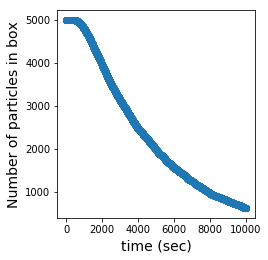

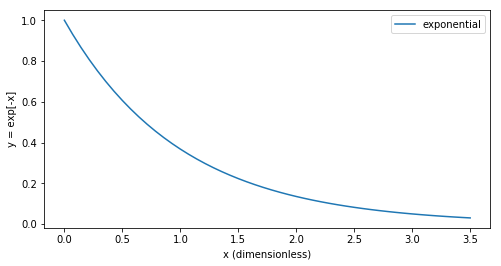

In [164]:
t = 10000
fig = plt.figure(figsize = (8,4))
ax2 = fig.add_subplot(122)
ax2.plot(Counter, 'o')
fig2 = plt.figure(figsize=(8,4))
ax1 = fig2.add_subplot(111)
time=np.linspace(0,3.5)
f = np.exp(-time)
ax1.plot(time,f,'-',label="exponential")
plt.legend()
ax1.set_xlabel("x (dimensionless)")
ax1.set_ylabel("y = exp[-x]")

ax2.set_xlabel("time (sec)", fontsize =14)
ax2.set_ylabel("Number of particles in box", fontsize = 14)

fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.45, hspace = 0.35)

plt.show()



So we see that the remaining particles in the box as a function of time varies as a damped exponential.

## Problem 3

Calculate the integral